# Create 3D Plot
Here we'll attempt to read up all of the data and try to replicate the graph below:


![Terry's Plot](images/LTO-HI-2018-08-30.png)

In [1]:
import numpy as np
import pandas as pd
from LTO_Utils import *
from os import listdir
from os.path import isfile, join
import re

## Load the Pickled FFT files

In [2]:
# get a list of all of .pcl files in the data directory
fftfiles = [f for f in listdir('data') if re.search('.*pcl$',f) ]

In [3]:
len(fftfiles)

1415

In [4]:
#pick a file at random and see what it looks like
df = get_pickled_fft(join('data',fftfiles[22]))

In [5]:
df.head()

,PWR,PWR_dBm,dF,dt
0,1.000000,0.000,-5000.00000,2018-08-30 00:22:26
1,1.000000,0.000,-4999.38965,2018-08-30 00:22:26
2,0.541047,-2.668,-4998.77930,2018-08-30 00:22:26
3,0.543276,-2.650,-4998.16895,2018-08-30 00:22:26
4,0.545477,-2.632,-4997.55859,2018-08-30 00:22:26


In [6]:
len(df)

16384

One row for each frequency bucket.

THe code below clips the returned data frame to include only frequencies +/- 700 of the base HI frequency of 1.4 Ghz.  This reduces the resulting data frame by a factor of about 8, which allows all of the minute-by-minute slices to fit into memory.

Without this clipping, the author's laptop hoses up.

In [7]:
df = get_pickled_fft(join('data',fftfiles[22]),dFclip=(-700.0,200.0))

In [8]:
len(df)

1474

In [9]:
df.head()

,PWR,PWR_dBm,dF,dt
7046,0.660551,-1.801,-699.46289,2018-08-30 00:22:26
7047,0.659771,-1.806,-698.85254,2018-08-30 00:22:26
7048,0.658310,-1.816,-698.24219,2018-08-30 00:22:26
7049,0.657614,-1.820,-697.63184,2018-08-30 00:22:26
7050,0.658026,-1.818,-697.02148,2018-08-30 00:22:26


In [25]:
df.tail()

,PWR,PWR_dBm,dF,dt
9334,0.669984,-1.739,697.02148,2018-08-30 23:59:10
9335,0.671378,-1.730,697.63184,2018-08-30 23:59:10
9336,0.671958,-1.727,698.24219,2018-08-30 23:59:10
9337,0.671548,-1.729,698.85254,2018-08-30 23:59:10
9338,0.671508,-1.729,699.46289,2018-08-30 23:59:10


In [26]:
# get the dataframe for each minute and concatenate into a long one:
df = pd.concat([get_pickled_fft(join('data',f),dFclip=(-700.0,200.0)) for f in fftfiles])

In [27]:
len(df)

2085710

## Create the 3d Plot

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm


%matplotlib inline
rcParams['figure.figsize'] = [10.0, 10.0]
rcParams['font.size'] = 14

In [29]:
import matplotlib.colors as colors
#from matplotlib.mlab import bivariate_n

### Put the Power Measurements in a 2d Array
The code above brings in the power measurements in a long (dataframe) format, where one column ('dF') indicates the row in a Frequency x Time matrix and another column ('dt' for datetime) indicates the column index. From this structure, we create the 2d Frequency x Time matrix of power measurements.

Note this code makes some assumptions about the order of the rows in the incoming data frame.  It needs to be 'robustified' to handle cases in which the data comes in an arbitrary order.

Note also that the data arrives in essentially column order: measurements for all of the frequencies for the first minute, followed by all of the measurements for the next minute and so on.  This is a Time x Frequency representation; to reproduce the plot above, the matrix needs transposition.

In [30]:
times = df['dt'].unique()
freqs = df['dF'].unique()
pwr = np.array(df['PWR']).reshape(len(times), len(freqs)).T #transpose to row order

### Plot It Out!

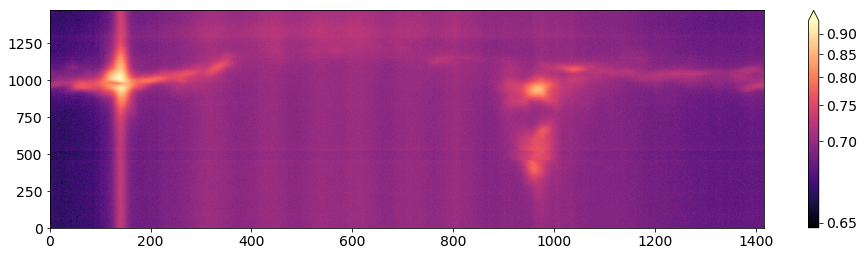

In [31]:

fig, ax = plt.subplots(figsize=(16,4))

pcm = ax.pcolormesh(pwr,
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()), #uncomment for log normalized
                    norm=colors.PowerNorm(gamma=1./2.),
                    cmap='magma')
fig.colorbar(pcm, ax=ax, extend='max')


#fig.show()


### Compare to the Original
![Terry's Plot](images/LTO-HI-2018-08-30.png)

Future versions of this notebook will improve upon axis labeling, coloring etc. For now this looks like a good first approximation.

## Noise Suppression

The dark areas in the two plots above suggest that most of the power measurements are noise level readings from random sources.
This graph shows frequency counts of power values bucketed into 30 bins.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024F97A48FD0>]], dtype=object)

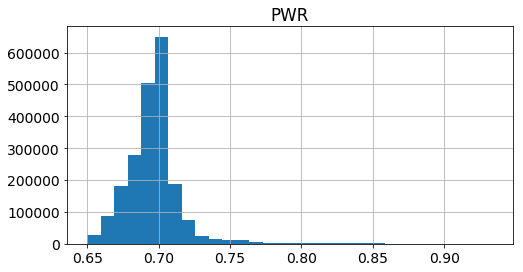

In [32]:
df.hist('PWR', bins=30, figsize=(8,4))

Perhaps there are some interesting frequency bumps out on the right tail of the distrubtion. The plot below shows frequency counts for power values greater than 0.77.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024F97BBF438>]], dtype=object)

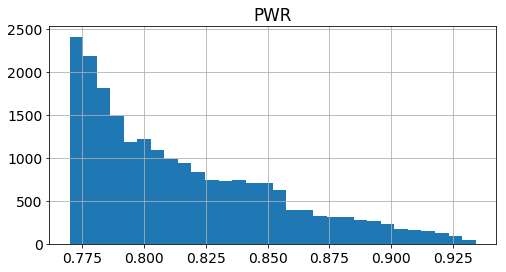

In [33]:
df.query('PWR >= 0.77').hist('PWR', bins=30, figsize=(8,4))

Nope, not much going on in the right tail of the frequency count curve.

In [34]:
#run this code if you have 20 minutes to kill
#df[['PWR']].plot.kde()

## Eliminate the Noise Readings

In [35]:
thresh = 0.7
pwr_nonoise = np.where(pwr > thresh, pwr, 0)

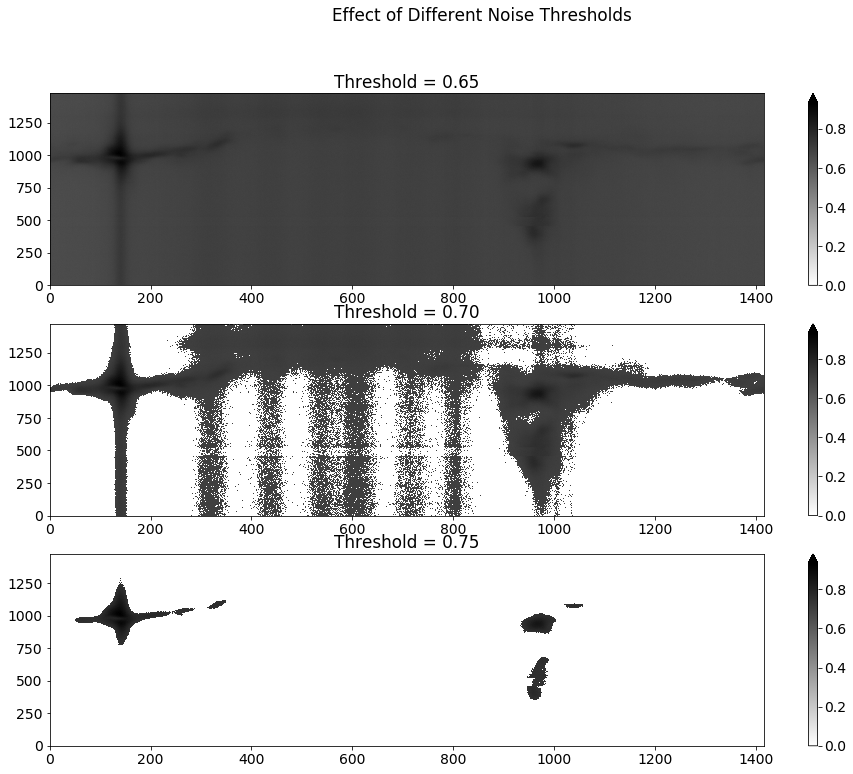

In [36]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Effect of Different Noise Thresholds')
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

pcm = ax1.pcolormesh(np.where(pwr>=0.65, pwr, 0),
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()),
                   cmap='binary')
ax1.set_title('Threshold = 0.65')
fig.colorbar(pcm, ax=ax1, extend='max')

pcm = ax2.pcolormesh(np.where(pwr>=0.70, pwr, 0),
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()),
                   cmap='binary')
ax2.set_title('Threshold = 0.70')
fig.colorbar(pcm, ax=ax2, extend='max')

pcm = ax3.pcolormesh(np.where(pwr>=0.75, pwr, 0),
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()),
                   cmap='binary')
ax3.set_title('Threshold = 0.75')
fig.colorbar(pcm, ax=ax3, extend='max')



## Future Reference: Adding a Rectangle to a Plot

In the near future, we'll want to identify features on the plot and highlight them. What better way than to draw a rectangle around them!
The code below draws a rectange at an aritrary point on the plot.

In [37]:
import matplotlib.patches as patches

In [38]:
# put a 100x500 rectangle (in axis units) arbitrarily at x=600, y=500
# parameter is lower left corner of rect, followed by xwidth, yheight
rect = patches.Rectangle((600,1000),100,500,linewidth=2,edgecolor='r',facecolor='none')

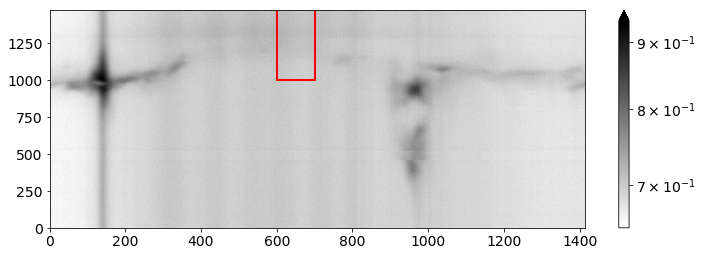

In [39]:
fig, ax = plt.subplots(figsize=(12,4))

pcm = ax.pcolormesh(pwr,
                   norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()),
                   cmap='binary')
ax.add_patch(rect)
fig.colorbar(pcm, ax=ax, extend='max')
